# Feature Detection

In [2]:
from pathlib import Path
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Read Image

Image Shape:  (1200, 1600, 3)


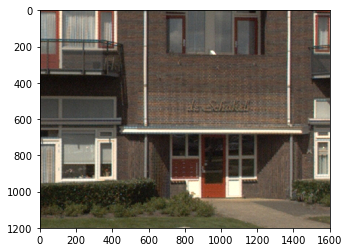

In [15]:
IMAGE_DIR = str(Path('images','train'))
PATH_TO_IMAGE = str(Path(IMAGE_DIR, '0003100000117676.jpeg'))

image = cv2.imread(PATH_TO_IMAGE)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
print("Image Shape: ", image.shape)
plt.imshow(image)

(1200, 1600)


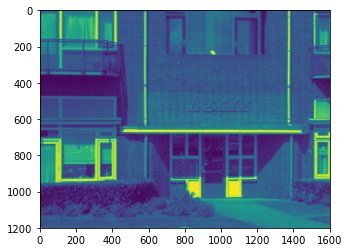

In [50]:
#Convert to Grayscale
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
print(gray.shape)
plt.imshow(gray)

## Edge Detection

Sobel filters are used to calculate the gradient of the image intensity in the horizontal and vertiacal directions. Locations of high intesity gradient capture the edges of the image, since that is where the pixel intensity changes significantly. The size and weights of each filter changes the amount and intensity of the detected edges.

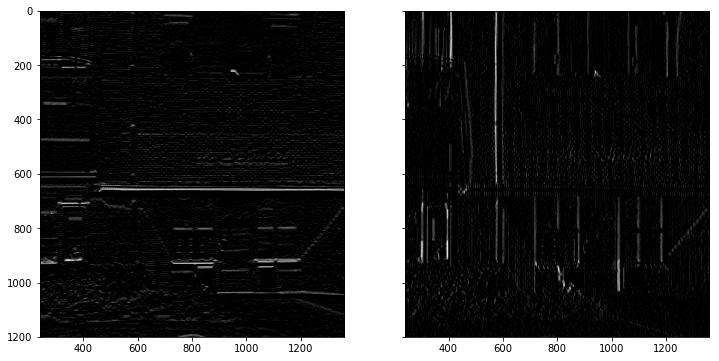

In [12]:

# 3x3 kernels for edge detection
sobel_y = np.array([[ -1, -2, -1], 
                   [ 0, 0, 0], 
                   [ 1, 2, 1]])

sobel_x = np.array([[-1, 0, 1],
                   [-2, 0, 2],
                   [-1, 0, 1]])

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12,6))

# Filter the image using filter2D, which has inputs: (grayscale image, bit-depth, kernel) 
filtered_image = cv2.filter2D(gray, -1, sobel_y)
ax1.imshow(filtered_image, cmap='gray')

filtered_image = cv2.filter2D(gray, -1, sobel_x)
ax2.imshow(filtered_image, cmap='gray')


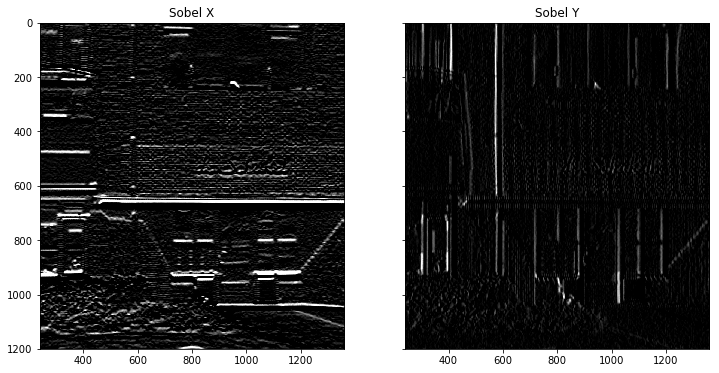

In [64]:
# 5x5 kernels for edge detection
sobel_y = np.array([[ -1, -1, -2, -1, -1], 
                    [ -1, -1, -2, -1, -1],
                   [ 0, 0, 0, 0, 0], 
                   [ 1, 1, 2, 1, 1],
                   [ 1, 1, 2, 1, 1]])

sobel_x = np.array([[-1, 0, 1],
                    [-1, 0, 1],
                   [-2, 0, 2],
                   [-1, 0, 1],
                   [-1, 0, 1]])

# Filter the image using filter2D, which has inputs: (grayscale image, bit-depth, kernel) 
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12,6))

ax1.set_title('Sobel X')
filtered_image = cv2.filter2D(gray, -1, sobel_y)
ax1.imshow(filtered_image, cmap='gray')

ax2.set_title('Sobel Y')
filtered_image = cv2.filter2D(gray, -1, sobel_x)
ax2.imshow(filtered_image, cmap='gray')

### Cannny Edge Detection

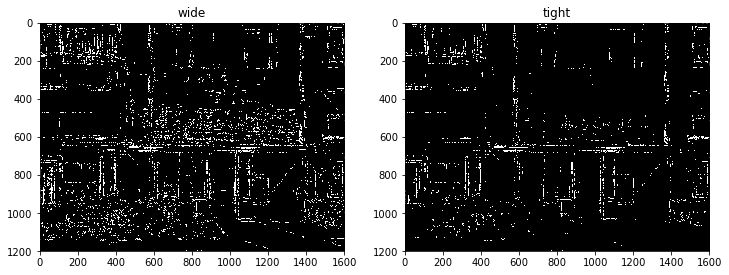

In [36]:
# Try Canny using "wide" and "tight" thresholds
wide = cv2.Canny(gray, 10, 50)
tight = cv2.Canny(gray, 30, 70)
 
# Display the images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))

ax1.set_title('wide')
ax1.imshow(wide, cmap='gray')

ax2.set_title('tight')
ax2.imshow(tight, cmap='gray')

### Hough Transformation

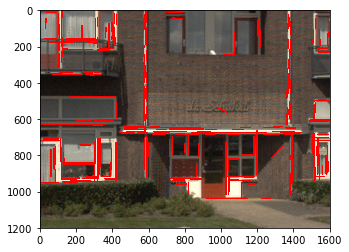

In [57]:
edges = tight

# Define the Hough transform parameters
# Make a blank the same size as our image to draw on
rho = 1
theta = np.pi/180
threshold = 60
min_line_length = 50
max_line_gap = 10

line_image = np.copy(image) #creating an image copy to draw lines on

# Run Hough on the edge-detected image
lines = cv2.HoughLinesP(edges, rho, theta, threshold, np.array([]),
                        min_line_length, max_line_gap)


# Iterate over the output "lines" and draw lines on the image copy
for line in lines:
    for x1,y1,x2,y2 in line:
        cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),5)
        
plt.imshow(line_image)

## Corner Detection

### Harris Corner Detection

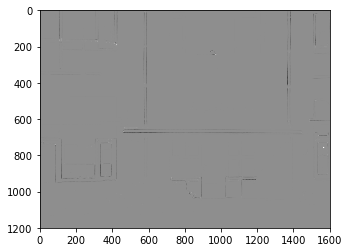

In [58]:
# Detect corners 
dst = cv2.cornerHarris(gray, 2, 3, 0.04)

# Dilate corner image to enhance corner points
dst = cv2.dilate(dst,None)

plt.imshow(dst, cmap='gray')

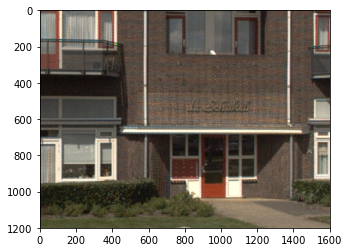

In [65]:
# This value vary depending on the image and how many corners you want to detect
# Try changing this free parameter, 0.1, to be larger or smaller ans see what happens
thresh = 0.4*dst.max()

# Create an image copy to draw corners on
corner_image = np.copy(image)

# Iterate through all the corners and draw them on the image (if they pass the threshold)
for j in range(0, dst.shape[0]):
    for i in range(0, dst.shape[1]):
        if(dst[j,i] > thresh):
            # image, center pt, radius, color, thickness
            cv2.circle( corner_image, (i, j), 1, (0,255,0), 1)

plt.imshow(corner_image)

## K Means Clustering

### Prepare data

In [33]:
# Reshape image into a 2D array of pixels and 3 color values (RGB)
pixel_vals = image.reshape((-1,3))
print(pixel_vals)

# Convert to float type
pixel_vals = np.float32(pixel_vals)

[[145  73  59]
 [146  74  60]
 [145  73  59]
 ...
 [141 126 107]
 [140 125 106]
 [140 125 106]]


2


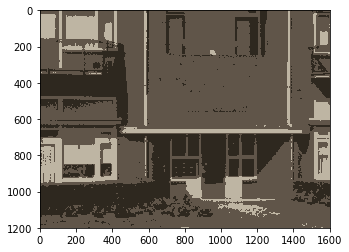

In [51]:
# define stopping criteria
# you can change the number of max iterations for faster convergence!
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)

# K sets the number of clusters detected
k = 3
retval, labels, centers = cv2.kmeans(pixel_vals, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

# convert data into 8-bit values
centers = np.uint8(centers)
segmented_data = centers[labels.flatten()]

# reshape data into the original image dimensions
segmented_image = segmented_data.reshape((image.shape))
labels_reshape = labels.reshape(image.shape[0], image.shape[1])

plt.imshow(segmented_image)

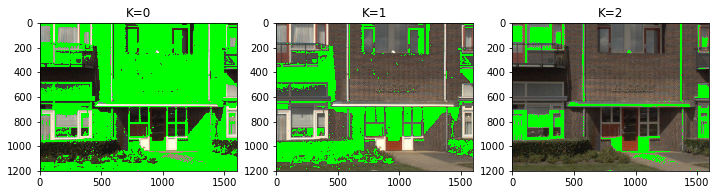

In [53]:
# Display the images
f, axes = plt.subplots(1, k, figsize=(12,6))

for i in range(k):
    
    masked_image = np.copy(image)
    # highlight locations of cluster
    masked_image[labels_reshape == i] = [0, 255, 0]

    plt.imshow(masked_image)
    
    axes[i].set_title("K=%s"%i)
    axes[i].imshow(masked_image, cmap='gray')